In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import scipy
from scipy.stats import beta, norm
import abc
from matplotlib.patches import PathPatch

In [2]:
# data_path = '/home/mmint/Desktop/pivoting_evaluation_results'
# datalegend_path = os.path.join(data_path, 'RAL_results_DataLegend.csv')

data_path = '/home/mmint/Desktop/pivoting_evaluation_results'
datalegend_path = os.path.join(data_path, 'last_results_Datalegend.csv')

loaded_df = pd.read_csv(datalegend_path)
loaded_df

,SceneName,ControllerMethod,Model,Version,Tool,InitAngle,GoalAngle,Achieved,AngleDiff,ToolDetected,NSteps
0,pivoting_evaluation,learned_mppi,bubble_dynamics_model,0.0,double_marker,0.290107,0.883719,True,-0.008539,True,5
1,pivoting_evaluation,learned_mppi,bubble_dynamics_model,0.0,double_marker,0.206574,-1.799788,True,0.003975,True,7
2,pivoting_evaluation,learned_mppi,bubble_dynamics_model,0.0,double_marker,-1.797891,2.411150,False,-0.432573,True,5
3,pivoting_evaluation,learned_mppi,bubble_dynamics_model,0.0,double_marker,0.283197,-1.154089,False,0.287187,True,4
4,pivoting_evaluation,learned_mppi,bubble_dynamics_model,0.0,double_marker,-1.381491,2.453795,True,0.046634,True,4
...,...,...,...,...,...,...,...,...,...,...,...
395,pivoting_evaluation,pose_learned_mppi,object_pose_dynamics_model,0.0,intermediate_stick_2,-0.561625,-0.477411,True,0.000210,True,0
396,pivoting_evaluation,pose_learned_mppi,object_pose_dynamics_model,0.0,intermediate_stick_2,-0.718673,0.139312,True,-0.035874,True,2
397,pivoting_evaluation,learned_mppi,bubble_dynamics_model,0.0,double_stick,0.643826,0.241577,True,-0.003174,True,1
398,pivoting_evaluation,learned_mppi,bubble_dynamics_model,0.0,double_stick,0.930230,2.182959,False,0.015376,True,9


In [3]:
for tool_i, counts_i in list(zip(*np.unique(loaded_df['Tool'], return_counts=True))):
    print(f'{tool_i}: {counts_i}')

dark_spatula: 50
dark_spoon: 50
double_marker: 50
double_stick: 50
intermediate_stick_2: 50
medium_stick: 50
thick_stick: 50
thin_rolling_pin: 50


In [4]:
# COMPUTE THE SCORES
def add_scores(df):
    df_out = df.copy()
#     df_out['ScoreAbs'] = np.abs(np.rad2deg((df['AngleDiff'] + np.pi/2) % np.pi - np.pi/2)) # old -- (-90,90)
    df_out['ScoreAbs'] = np.abs(np.rad2deg((df['AngleDiff'] + np.pi) % (2*np.pi) - np.pi)) # new -- (-180,180)
    df_out['Score'] = - df_out['ScoreAbs'] * np.sign((df_out['GoalAngle']-df_out['InitAngle'])*(df['AngleDiff']))
    return df_out

In [5]:
df = add_scores(loaded_df)

In [6]:
loaded_df[loaded_df['Model']=='bubble_dynamics_model']

,SceneName,ControllerMethod,Model,Version,Tool,InitAngle,GoalAngle,Achieved,AngleDiff,ToolDetected,NSteps
0,pivoting_evaluation,learned_mppi,bubble_dynamics_model,0.0,double_marker,0.290107,0.883719,True,-0.008539,True,5
1,pivoting_evaluation,learned_mppi,bubble_dynamics_model,0.0,double_marker,0.206574,-1.799788,True,0.003975,True,7
2,pivoting_evaluation,learned_mppi,bubble_dynamics_model,0.0,double_marker,-1.797891,2.411150,False,-0.432573,True,5
3,pivoting_evaluation,learned_mppi,bubble_dynamics_model,0.0,double_marker,0.283197,-1.154089,False,0.287187,True,4
4,pivoting_evaluation,learned_mppi,bubble_dynamics_model,0.0,double_marker,-1.381491,2.453795,True,0.046634,True,4
...,...,...,...,...,...,...,...,...,...,...,...
354,pivoting_evaluation,learned_mppi,bubble_dynamics_model,0.0,intermediate_stick_2,-1.286209,1.975714,True,0.053091,True,3
355,pivoting_evaluation,learned_mppi,bubble_dynamics_model,0.0,intermediate_stick_2,1.880230,1.932461,False,-0.524007,True,3
356,pivoting_evaluation,learned_mppi,bubble_dynamics_model,0.0,intermediate_stick_2,0.964506,0.312260,True,-0.026421,True,2
397,pivoting_evaluation,learned_mppi,bubble_dynamics_model,0.0,double_stick,0.643826,0.241577,True,-0.003174,True,1


# Define colors and names:

In [7]:
# DEFINE MODEL-CONTROL NAMES AND THEIR LABES TO BE DISPLAYED ON THE PLOTS:
control_name_mapping = None
learned_models = ['bubble_dynamics_model','bubble_linear_dynamics_model','object_pose_dynamics_model']
not_learned_models = ['jacobian','random']

control_name_mapping_base = {
    'bubble_dynamics_model':'Bubble Dynamics (Train)',
    'bubble_linear_dynamics_model': 'Bubble Linear Dynamics (Train)',
    'object_pose_dynamics_model': 'Object Pose Dynamics (Train)',
    'jacobian': 'Jacobian (Train)',
    'random': 'Random (Train)',
    
}
control_name_mapping_test = {
    'bubble_dynamics_model_test':'Bubble Dynamics (Test)',
    'bubble_linear_dynamics_model_test': 'Bubble Linear Dynamics (Test)',
    'object_pose_dynamics_model_test': 'Object Pose Dynamics (Test)',
    'jacobian_test': 'Jacobian (Test)',
    'random_test': 'Random (Test)',
}
control_name_mapping = control_name_mapping_base.copy()
control_name_mapping.update(control_name_mapping_test)
# DEFINE THE MODEL-CONTROL ORDER TO BE DISPLAYED ON THE PLOTS:

model_order = None

def intercalar_dicts_keys(dict_list):
    out = []
    lens = [len(d_i) for d_i in dict_list]
    for i in range(np.max(lens)):
        for d_i in dict_list:
            if i < len(d_i):
                out.append(list(d_i.keys())[i])
    return out
model_order = intercalar_dicts_keys([control_name_mapping_base, control_name_mapping_test])

In [8]:
def rename_controller_method(df):
    df_out = df.copy()
    controller_methods_out = []
    for indx, row  in df.iterrows():
        controller_i = row['ControllerMethod']
        model_i = row['Model']
        if controller_i in not_learned_models:
            controller_method_out_i = controller_i
        else:
            controller_method_out_i = model_i
        controller_methods_out.append(controller_method_out_i)
    df_out['ControllerMethod'] = controller_methods_out
    return df_out


In [9]:
df = rename_controller_method(df)

In [10]:
np.unique(df['ControllerMethod'])

array(['bubble_dynamics_model', 'bubble_linear_dynamics_model',
       'jacobian', 'object_pose_dynamics_model', 'random'], dtype=object)

In [11]:
# DEFINE OBJECT NAMES AND THEIR CATEGORIES ----------

train_objects = ['medium_stick', 'thick_stick', 'double_marker', 'thin_rolling_pin', 'double_stick']
test_objects = ['dark_spatula', 'dark_spoon', 'intermediate_stick_2']
all_objects = train_objects + test_objects


In [12]:
## DEFINE THE PALETTES -------------------------------

palette = None
base_palette = sns.color_palette("tab10")
palette = dict(zip(all_objects,[base_palette[o_i] for o_i, obj_i in enumerate(all_objects)]))
# add model names to it:
model_palette_list = [c_i for c_i in sns.color_palette('Set2')] + [c_i for c_i in sns.color_palette("husl", 8)]


object_palette_list = sns.color_palette("tab10")[:5]+sns.color_palette("pastel")[:]


palette = {}
# Model palette
for i, control_name_i in enumerate(control_name_mapping.keys()):
    palette[control_name_i] = model_palette_list[i]
    
# Object name palette
for i, obj_name_i in enumerate(all_objects):
    palette[obj_name_i] = object_palette_list[i]

# Clean Data, Filter Out, and Rename

In [13]:
# Rename data for 
base_df = df
learned_model_data = base_df[base_df.ControllerMethod.isin(learned_models)]
not_learned_model_data = base_df[base_df.ControllerMethod.isin(not_learned_models)]


train_data_learned = learned_model_data[learned_model_data.Tool.isin(train_objects)]
train_data_fixed_random = not_learned_model_data[not_learned_model_data.Tool.isin(train_objects)]
test_data_learned = learned_model_data[learned_model_data.Tool.isin(test_objects)]
test_data_fixed_random = not_learned_model_data[not_learned_model_data.Tool.isin(test_objects)]
# map the data from test learned to the basic names


train_data = pd.concat([train_data_learned, train_data_fixed_random], ignore_index=True)
test_data = pd.concat([test_data_learned, test_data_fixed_random], ignore_index=True)
test_data['ControllerMethod'] = test_data['ControllerMethod'] + '_test'

filtered_data = pd.concat([train_data, test_data], ignore_index=True)



In [14]:
np.unique(learned_model_data['ControllerMethod'])
np.unique(learned_model_data['Tool'])

array(['dark_spatula', 'dark_spoon', 'double_marker', 'double_stick',
       'intermediate_stick_2', 'medium_stick', 'thick_stick',
       'thin_rolling_pin'], dtype=object)

# Plot

In [15]:
sns.set(rc = {'figure.figsize':(30,8)}, font_scale=2)


class ScorePlotBase(object):
    def __init__(self, palette=None):
        self.palette = palette
    
    def _filter_df(self, df, add_args):
        return df
    
    @abc.abstractmethod
    def _plot_df(self, df, score_name, object_name, hue):
        pass
    
    def _customize_ax(self, ax, add_args):
        return ax
    
    def __call__(self, df, score_name, object_name=None, hue=None):
        add_args = {'score_name': score_name, 'object_name': object_name, 'hue': hue}
        data_df, add_args = self._filter_df(df, add_args)
        ax = self._plot_df(data_df, score_name, object_name, hue)
        ax = self._customize_ax(ax, add_args)
        
        return ax
    
    
class ScorePlot(ScorePlotBase):
    def _filter_df(self, df, add_args):
        object_name = add_args['object_name']
        if object_name is not None:
            if type(object_name) in [str]:
                data_df = df[df.Tool == object_name]
            elif type(object_name) in [list, tuple, np.ndarray]:
                data_df = df[df.Tool.isin(object_name)]
            else:
                raise AttributeError('Argument Not supported {} type {}'.format(object_name, type(object_name)))
        else:
            data_df = df
            object_name = np.unique(df.Tool) # All object names
            
        add_args['object_name'] = object_name
        return data_df, add_args
    
    def _customize_ax(self, ax, add_args):
        object_name = add_args['object_name']
        ax.set_title('Object: {}'.format(object_name))
        if control_name_mapping is not None:
            current_labels = [label._text for label in ax.get_xticklabels()]
            mapped_labels = []
            for label in current_labels:
                if label in control_name_mapping:
                    mapped_label_i = control_name_mapping[label]
                else:
                    mapped_label_i = label
                mapped_label_i = mapped_label_i.replace(' ', '\n')
                mapped_labels.append(mapped_label_i)
            ax.set_xticklabels(mapped_labels)
        ax.set_ylabel('Angle Difference (Goal - Achieved)')
#         plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.legend(bbox_to_anchor=(1.01, 0.8), loc='upper left', borderaxespad=0)
        return ax
    
    def _get_extra_arguments(self, df):
        extra_args = {}
        controllers = np.unique(df['ControllerMethod'])
        order = [m for m in model_order if m in controllers]
        extra_args['order'] = order
        extra_args['palette'] = self.palette
        return extra_args

class ScoreBoxPlot(ScorePlot):
    def __init__(self, *args, whis=1, **kwargs):
        self.whis = whis
        super().__init__(*args, **kwargs)
        
    def _plot_df(self, df, score_name, object_name, hue):
        extra_args = self._get_extra_arguments(df)
        ax = sns.boxplot(x='ControllerMethod', y=score_name, data=df, whis=self.whis, hue=hue, **extra_args)
        return ax
    
    
class ScoreBoxenPlot(ScorePlot):
    def __init__(self, *args, trust_alpha=0.05, **kwargs):
        self.trust_alpha = trust_alpha
        super().__init__(*args, **kwargs)
        
    def _plot_df(self, df, score_name, object_name, hue):
        extra_args = self._get_extra_arguments(df)
        ax = sns.boxenplot(x='ControllerMethod', y=score_name, data=df, hue=hue, trust_alpha=self.trust_alpha,**extra_args)
        return ax

    
class ScoreViolinPlot(ScorePlot):
    def __init__(self, *args, bw=1, cut=2, **kwargs):
        self.bw = bw
        self.cut = cut
        super().__init__(*args, **kwargs)
        
    def _plot_df(self, df, score_name, object_name, hue):
        extra_args = self._get_extra_arguments(df)
        ax = sns.violinplot(x='ControllerMethod', y=score_name, data=df, bw=self.bw, hue=hue, cut=self.cut, inner=None,
                            **extra_args)
        return ax

    
class ScoreStripPlot(ScorePlot):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def _plot_df(self, df, score_name, object_name, hue):
        extra_args = self._get_extra_arguments(df)
        ax = sns.pointplot(x='ControllerMethod', y=score_name, data=df, join=False, dodge=True, alpha=0.1, markers="d", hue=hue, label=None, 
                           **extra_args)
        ax = sns.stripplot(x='ControllerMethod', y=score_name, data=df, hue=hue, jitter=True, 
                           **extra_args)
        ax.legend_.remove()
        return ax
    
class ScoreSwarmPlot(ScorePlot):
    def __init__(self, *args, size=5, **kwargs):
        self.size = size
        super().__init__(*args, **kwargs)
        
    def _plot_df(self, df, score_name, object_name, hue):
        extra_args = self._get_extra_arguments(df)
        ax = sns.swarmplot(x='ControllerMethod', y=score_name, data=df, hue=hue, size=self.size, 
                           **extra_args)
        return ax
    
class ScoreHistPlot(ScorePlot):
    def __init__(self, *args, bins='auto', **kwargs):
        self.bins = bins
        super().__init__(*args, **kwargs)
        
    def _plot_df(self, df, score_name, object_name, hue):
#         ax = sns.histplot(y='ControllerMethod', x=score_name, data=df, hue='ControllerMethod', bins=self.bins, palette=self.palette,  hue_order=model_order, legend=False)
        ax = sns.histplot(y='ControllerMethod', x=score_name, data=df, bins=self.bins, hue=hue, legend=False, palette=self.palette)
#         palette = sns.color_palette("flare")
#         ax = sns.histplot(x='ControllerMethod', y=score_name, data=df, bins=self.bins)
        
        return ax 
    
    def _customize_ax(self, ax, add_args):
        object_name = add_args['object_name']
        ax.set_title('Object: {}'.format(object_name))
#         if control_name_mapping is not None:
#             current_labels = [label._text for label in ax.get_yticklabels()]
#             mapped_labels = []
#             for label in current_labels:
#                 if label in control_name_mapping:
#                     mapped_label_i = control_name_mapping[label]
#                 else:
#                     mapped_label_i = label
#                 mapped_labels.append(mapped_label_i)
#             ax.set_yticklabels(mapped_labels)
        ax.set_ylabel('Drawing Score')
        return ax
    

class CustomScoreMeanStdPlot(ScorePlot):
    def _plot_df(self, df, score_name, object_name, hue):
        extra_args = self._get_extra_arguments(df)
        extra_args['palette'] = None
        ax = sns.pointplot(x='ControllerMethod', y=score_name, data=df, join=True, dodge=True, scale=1, markers="_", hue=hue,
                           label=None, ci='sd', errwidth=5, **extra_args, color='k', capsize=.5)
#         self._adjust_box_widths(ax, 0.1)
        return ax
    
    def _adjust_box_widths(self, ax, fac):
        """
        Adjust the withs of a seaborn-generated boxplot.
        """
        for c in ax.get_children():
            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])
                        
                        
class CustomScoreStdPlot(ScorePlot):
    def _plot_df(self, df, score_name, object_name, hue):
        extra_args = self._get_extra_arguments(df)
        extra_args['palette'] = None
        ax = sns.pointplot(x='ControllerMethod', y=score_name, data=df, join=False, dodge=True, scale=1, markers="_", hue=hue,
                           label=None, ci='sd', errwidth=5, **extra_args, color='k', capsize=.5)
#         self._adjust_box_widths(ax, 0.1)
        return ax

In [16]:
score_box_plot = ScoreBoxPlot(palette=palette)
score_violin_plot = ScoreViolinPlot(palette=palette, bw=0.2,cut=0)
score_boxen_plot = ScoreBoxenPlot(palette=palette)
score_strip_plot = ScoreStripPlot(palette=palette)
score_swarm_plot = ScoreSwarmPlot(palette=palette, size=10)
custom_score_mean_std_plot = CustomScoreMeanStdPlot(palette=palette)
score_hist_plot = ScoreHistPlot(palette=palette, bins='doane')
custom_score_std_plot = CustomScoreStdPlot(palette=palette)

In [17]:
# SCALING FUNCTIONS

def scaling_forward(exp_value=1):
    def func(x):
        return (np.abs(x))**(1/exp_value) * np.sign(x)
    return func

def scaling_inverse(exp_value=1):
    def func_inv(x):
        return (np.abs(x))**exp_value * np.sign(x)
    return func_inv



No handles with labels found to put in legend.
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


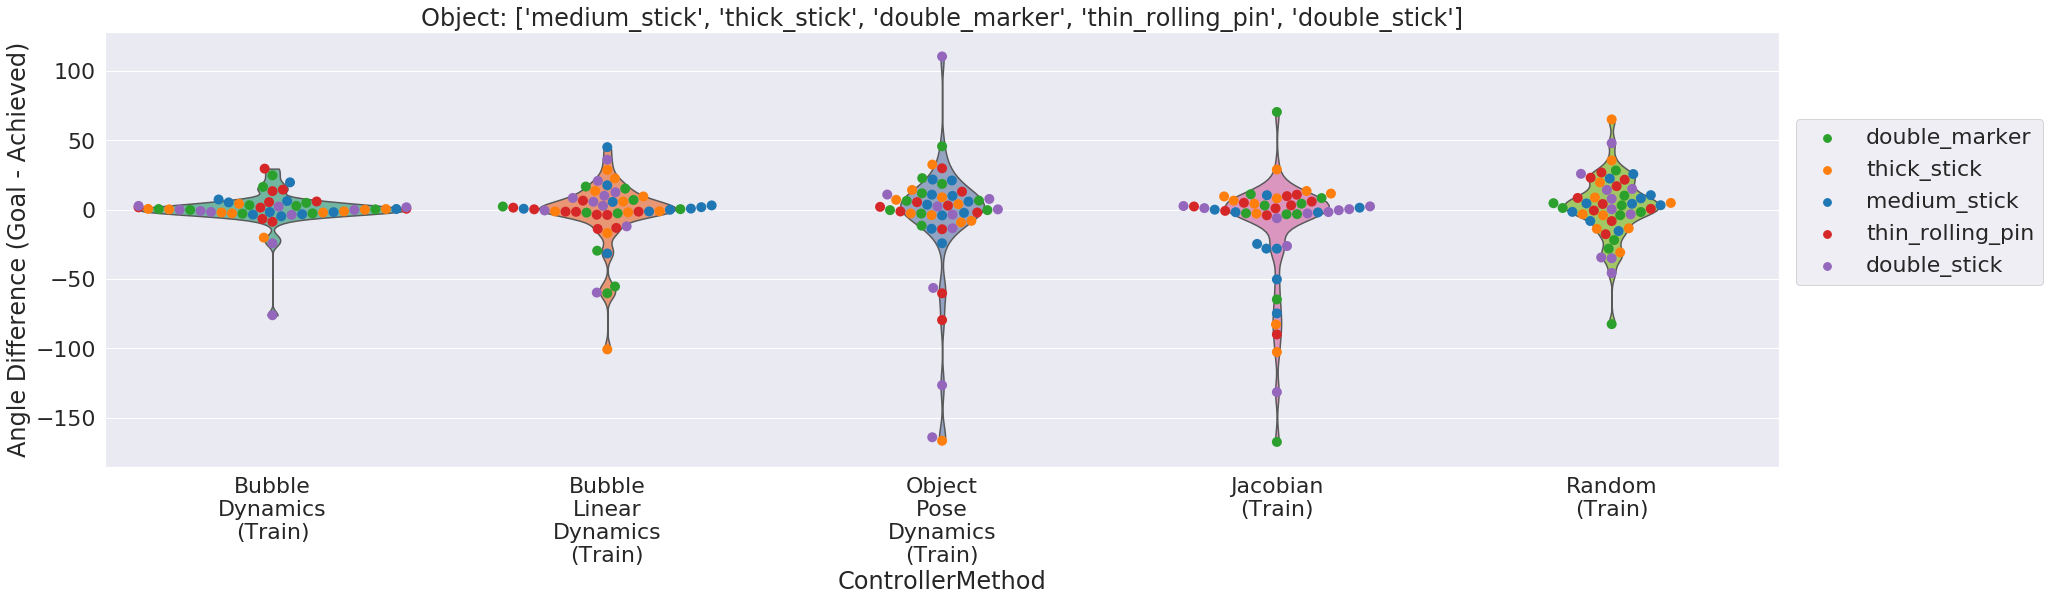

In [18]:
ax = score_violin_plot(filtered_data, 'Score', object_name=train_objects) # ALL
ax_2 = score_swarm_plot(filtered_data, 'Score', object_name=train_objects, hue='Tool')
# ax_3 = custom_score_mean_std_plot(filtered_data, 'Score', object_name=train_objects)

No handles with labels found to put in legend.
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


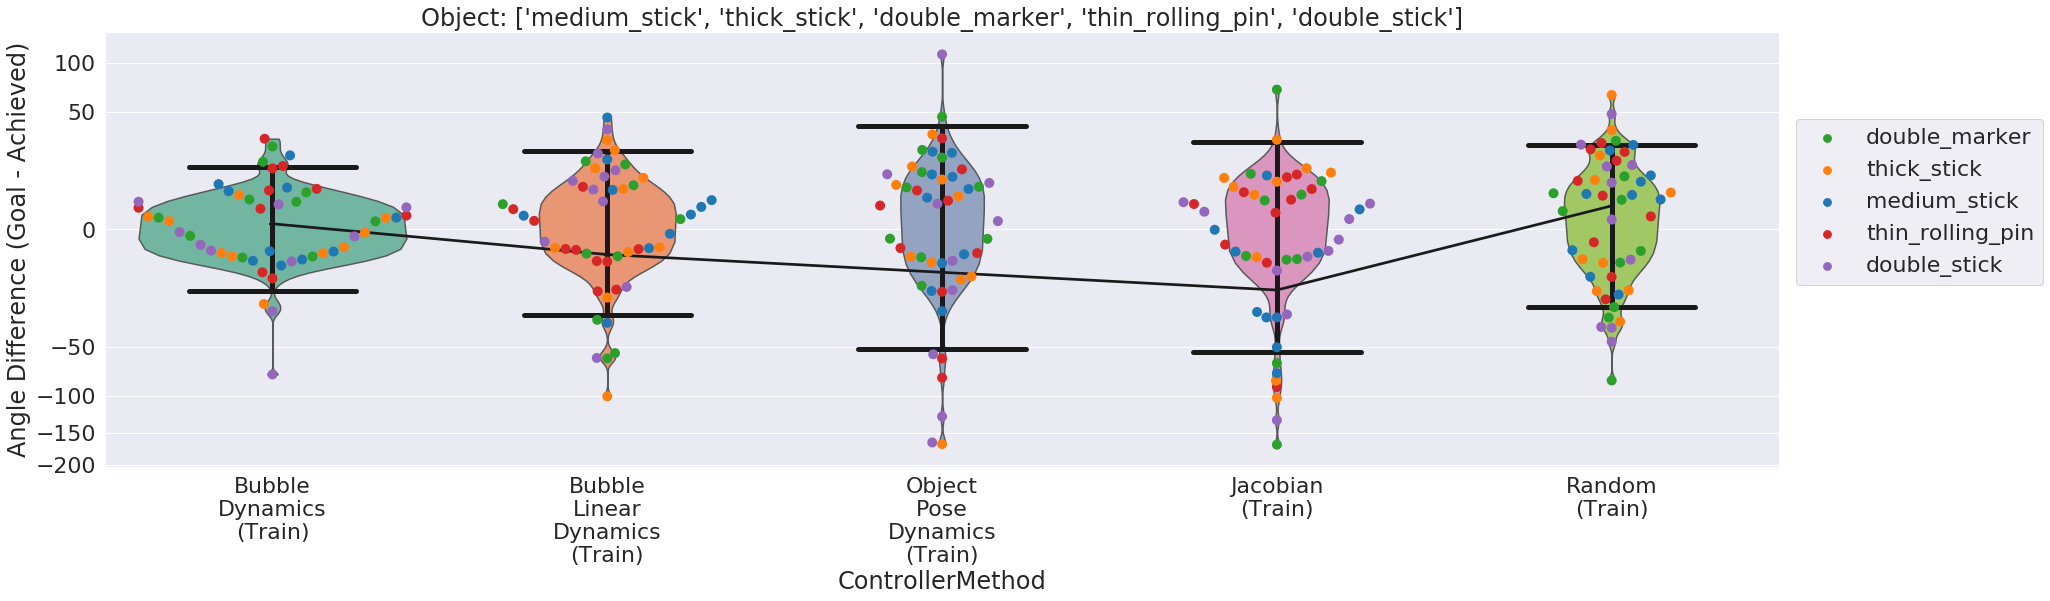

In [19]:
ax = score_violin_plot(filtered_data, 'Score', object_name=train_objects) # ALL
ax_2 = score_swarm_plot(filtered_data, 'Score', object_name=train_objects, hue='Tool')
ax_3 = custom_score_mean_std_plot(filtered_data, 'Score', object_name=train_objects)
ax.set_yscale('function', functions=(scaling_forward(2), scaling_inverse(2)))

No handles with labels found to put in legend.
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


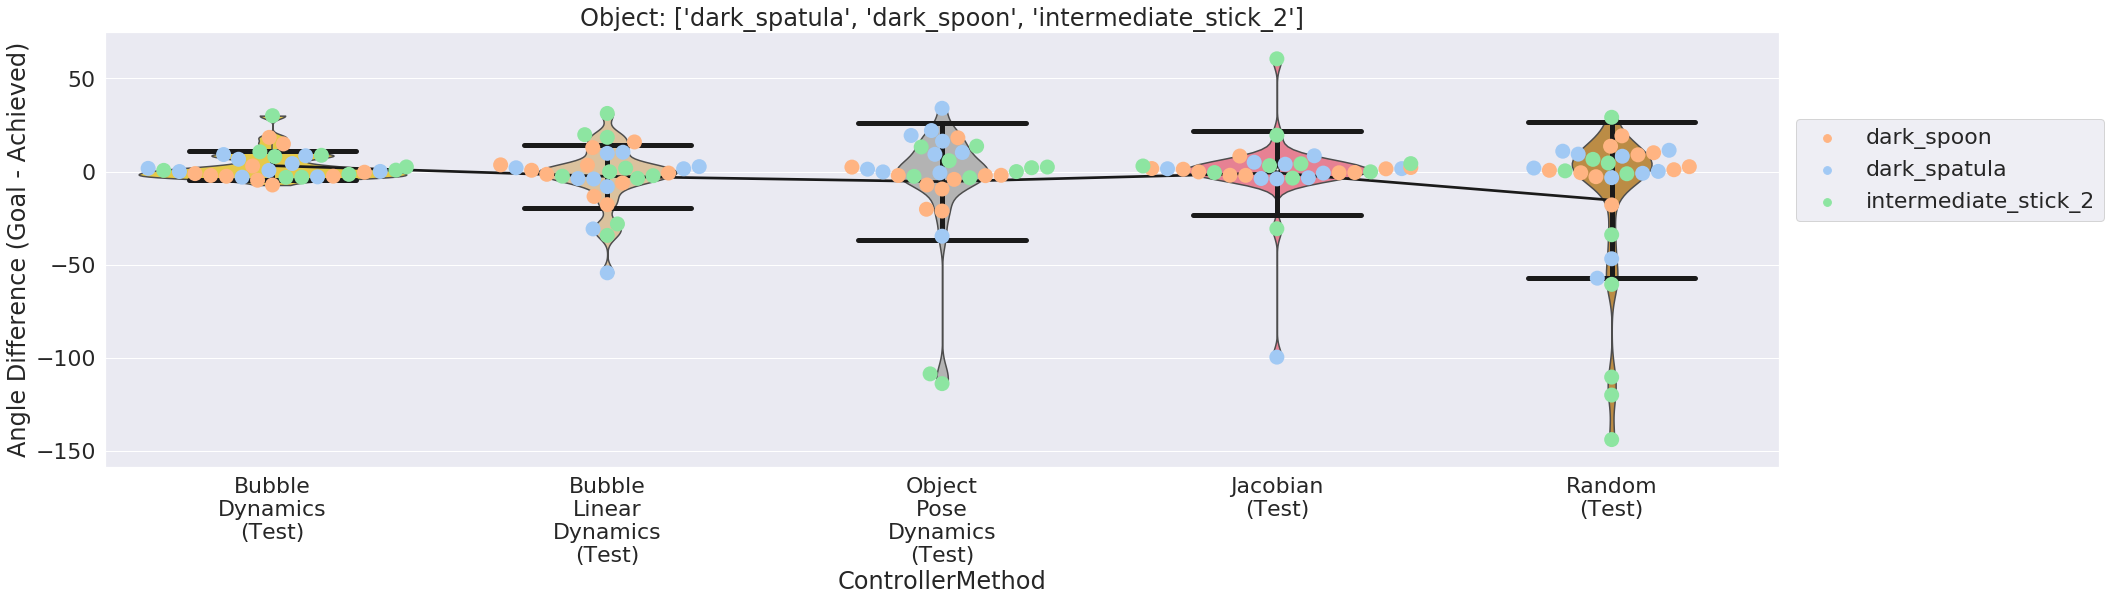

In [21]:
ax = score_violin_plot(filtered_data, 'Score', object_name=test_objects) # ALL
ax_2 = score_swarm_plot(filtered_data, 'Score', object_name=test_objects, hue='Tool')
ax_3 = custom_score_mean_std_plot(filtered_data, 'Score', object_name=test_objects)

No handles with labels found to put in legend.
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


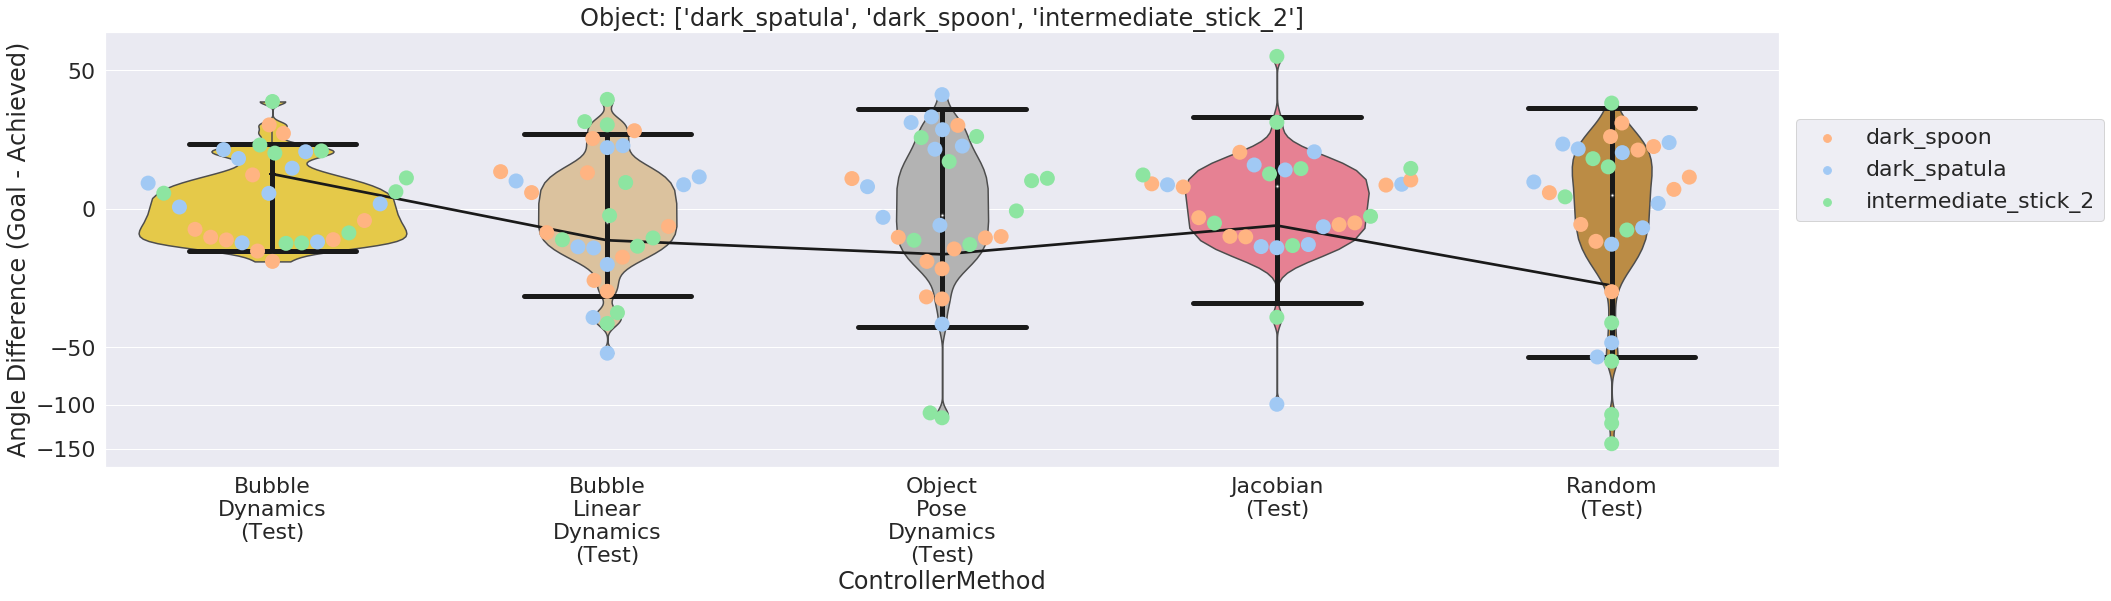

In [22]:
ax = score_violin_plot(filtered_data, 'Score', object_name=test_objects) # ALL
ax_2 = score_swarm_plot(filtered_data, 'Score', object_name=test_objects, hue='Tool')
ax_3 = custom_score_mean_std_plot(filtered_data, 'Score', object_name=test_objects)
ax.set_yscale('function', functions=(scaling_forward(2), scaling_inverse(2)))

No handles with labels found to put in legend.
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 52.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 36.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 34.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 26.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserW

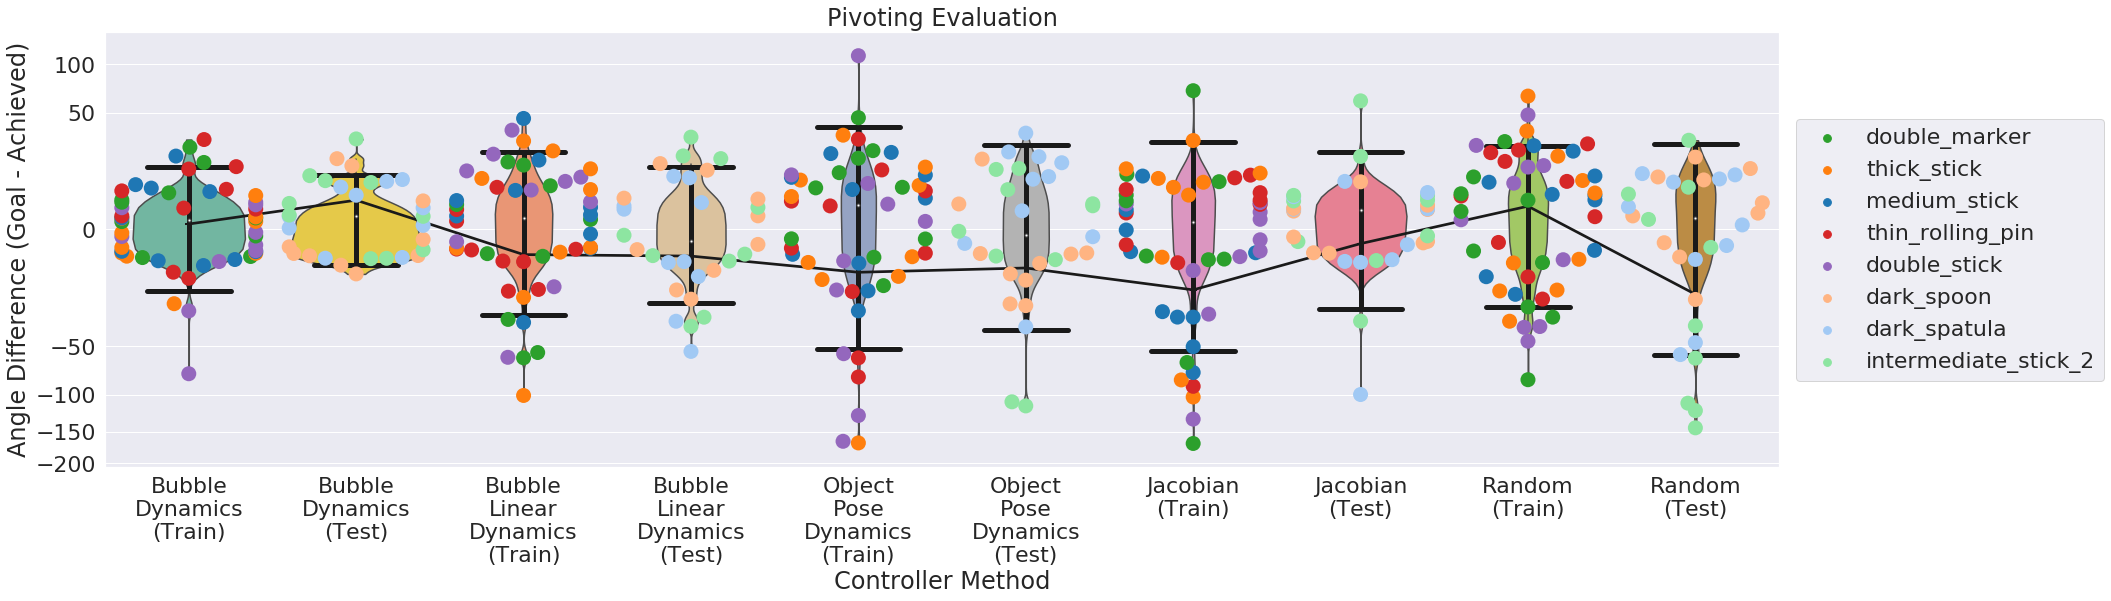

In [24]:
ax = score_violin_plot(filtered_data, 'Score', object_name=all_objects) # ALL
ax_2 = score_swarm_plot(filtered_data, 'Score', object_name=all_objects, hue='Tool')
ax_3 = custom_score_mean_std_plot(filtered_data, 'Score', object_name=all_objects)
ax.set_yscale('function', functions=(scaling_forward(2), scaling_inverse(2)))
ax.set_title('Pivoting Evaluation')
ax.set_xlabel('Controller Method')

fig = ax.get_figure()
plot_path = os.path.join(data_path, 'evaluation_plots')
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
plt.savefig(os.path.join(plot_path, 'pivoting_evaluation.pdf'), bbox_inches='tight')

No handles with labels found to put in legend.
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 32.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserW

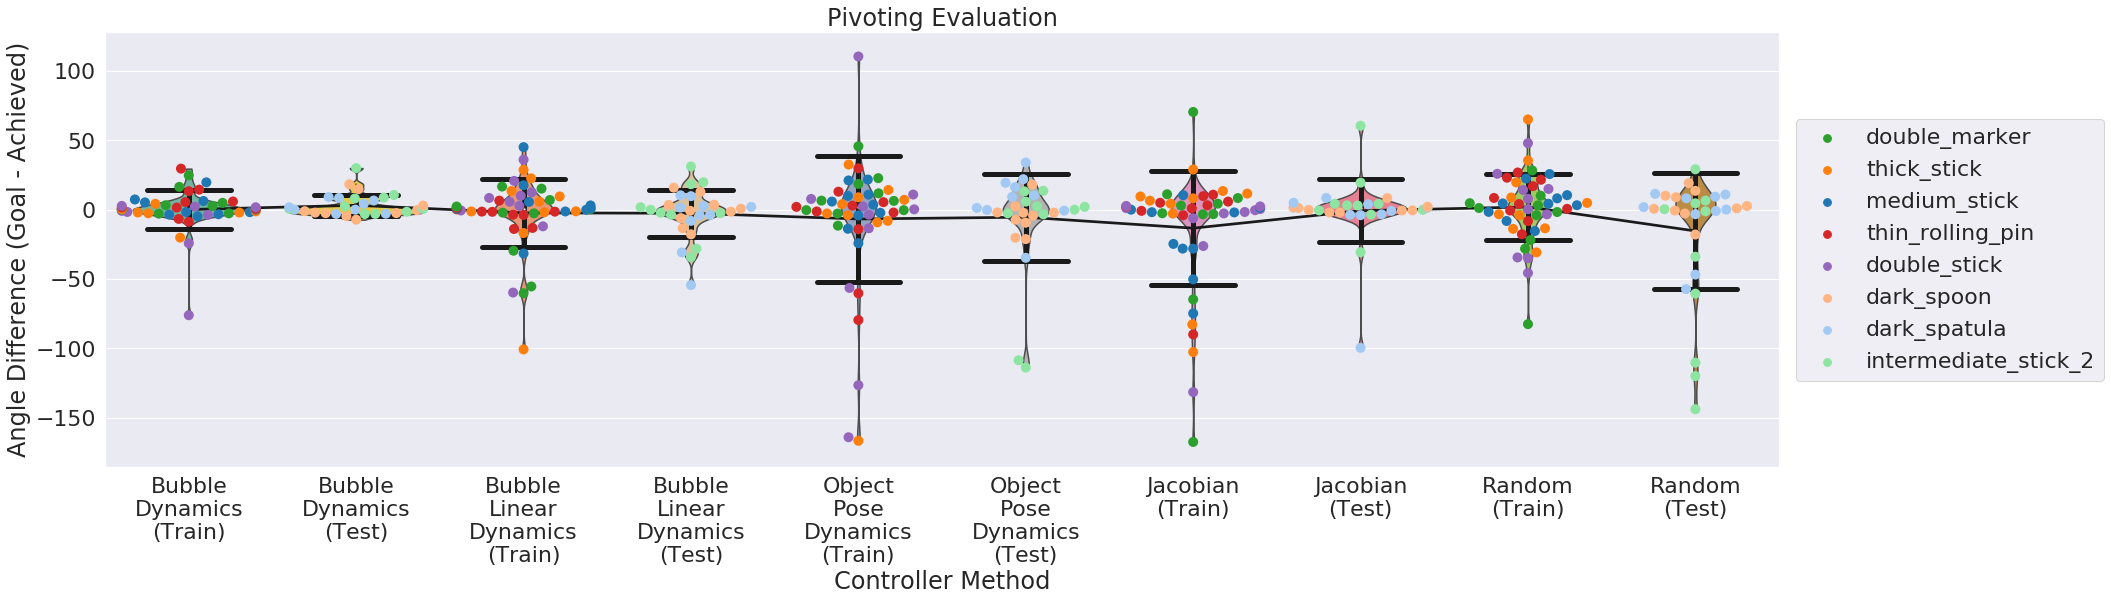

In [29]:
ax = score_violin_plot(filtered_data, 'Score', object_name=all_objects) # ALL
ax_2 = score_swarm_plot(filtered_data, 'Score', object_name=all_objects, hue='Tool')
ax_3 = custom_score_mean_std_plot(filtered_data, 'Score', object_name=all_objects)
# ax.set_yscale('function', functions=(scaling_forward(2), scaling_inverse(2)))
ax.set_title('Pivoting Evaluation')
ax.set_xlabel('Controller Method')

fig = ax.get_figure()
plot_path = os.path.join(data_path, 'evaluation_plots')
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
plt.savefig(os.path.join(plot_path, 'pivoting_evaluation.pdf'), bbox_inches='tight')

No handles with labels found to put in legend.
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 32.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserW

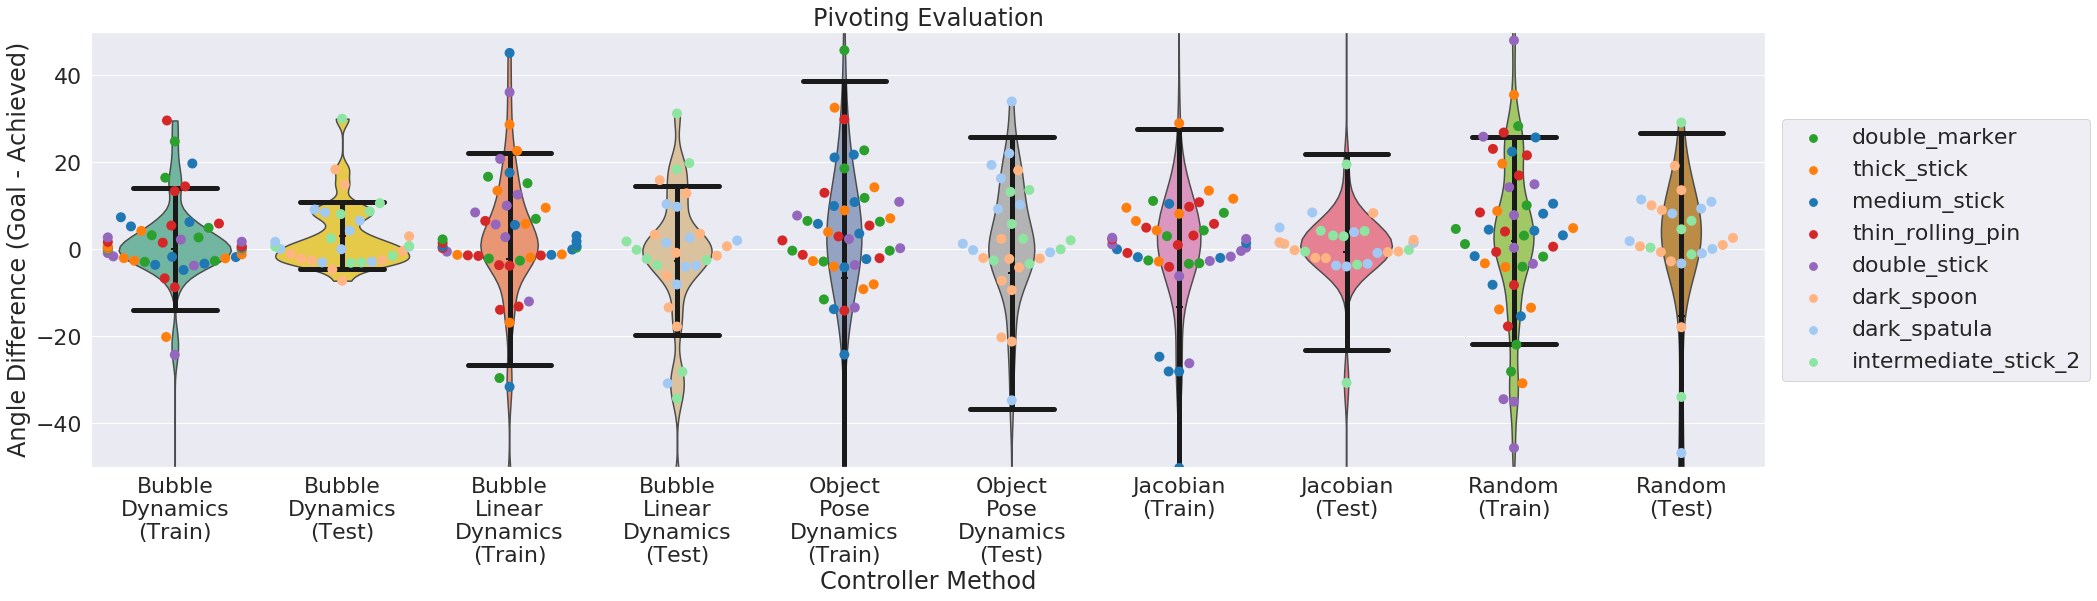

In [52]:
ax = score_violin_plot(filtered_data, 'Score', object_name=all_objects) # ALL
ax_2 = score_swarm_plot(filtered_data, 'Score', object_name=all_objects, hue='Tool')
# ax_3 = custom_score_mean_std_plot(filtered_data, 'Score', object_name=all_objects)
ax_3 = custom_score_std_plot(filtered_data, 'Score', object_name=all_objects)
ax.set_ylim((-50,50))
# ax.set_yscale('function', functions=(scaling_forward(2), scaling_inverse(2)))
ax.set_title('Pivoting Evaluation')
ax.set_xlabel('Controller Method')

fig = ax.get_figure()
plot_path = os.path.join(data_path, 'evaluation_plots')
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
plt.savefig(os.path.join(plot_path, 'pivoting_evaluation.pdf'), bbox_inches='tight')

No handles with labels found to put in legend.
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 36.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 18.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWa

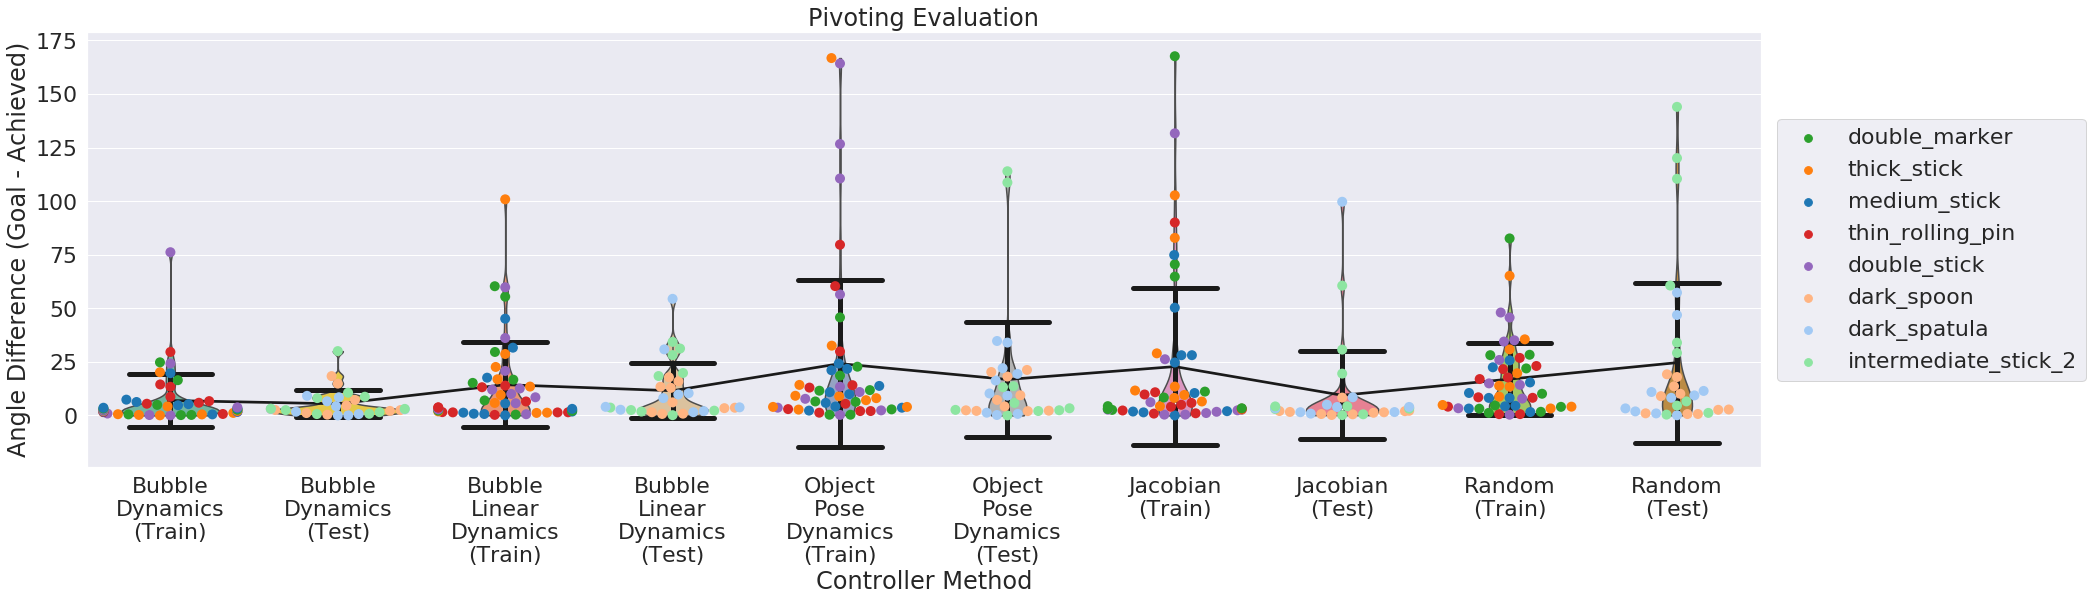

In [33]:
ax = score_violin_plot(filtered_data, 'ScoreAbs', object_name=all_objects) # ALL
ax_2 = score_swarm_plot(filtered_data, 'ScoreAbs', object_name=all_objects, hue='Tool')
ax_3 = custom_score_mean_std_plot(filtered_data, 'ScoreAbs', object_name=all_objects)
# ax.set_yscale('function', functions=(scaling_forward(2), scaling_inverse(2)))
ax.set_title('Pivoting Evaluation')
ax.set_xlabel('Controller Method')

fig = ax.get_figure()
plot_path = os.path.join(data_path, 'evaluation_plots')
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
plt.savefig(os.path.join(plot_path, 'pivoting_evaluation.pdf'), bbox_inches='tight')

No handles with labels found to put in legend.
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 36.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 18.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWa

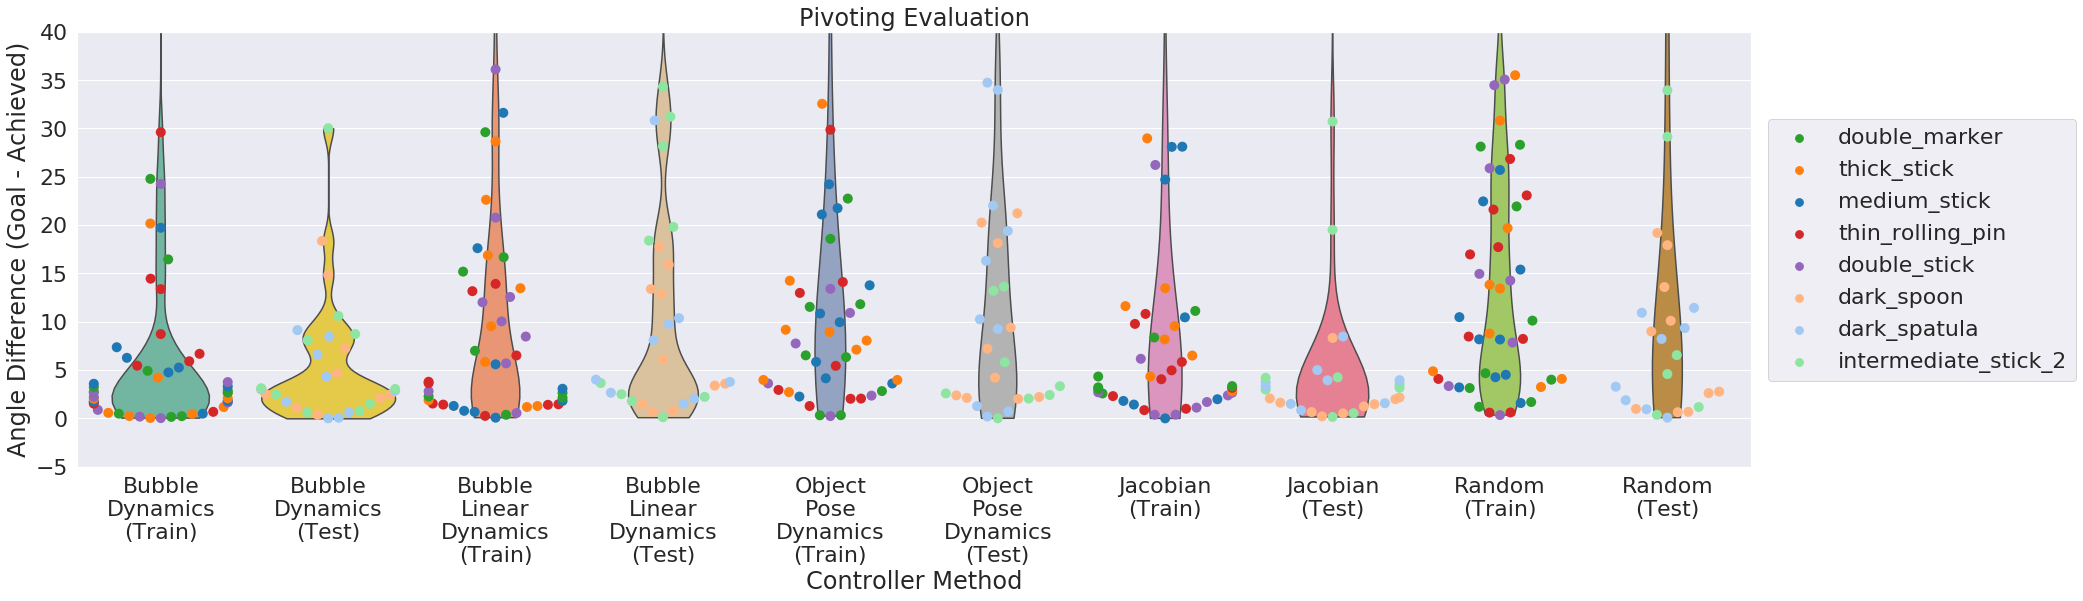

In [23]:
ax = score_violin_plot(filtered_data, 'ScoreAbs', object_name=all_objects) # ALL
ax_2 = score_swarm_plot(filtered_data, 'ScoreAbs', object_name=all_objects, hue='Tool')
# ax_3 = custom_score_mean_std_plot(filtered_data, 'ScoreAbs', object_name=all_objects)
# ax.set_yscale('function', functions=(scaling_forward(2), scaling_inverse(2)))
ax.set_title('Pivoting Evaluation')
ax.set_xlabel('Controller Method')
ax.set_ylim((-5,40))
fig = ax.get_figure()
plot_path = os.path.join(data_path, 'evaluation_plots')
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
plt.savefig(os.path.join(plot_path, 'pivoting_evaluation.pdf'), bbox_inches='tight')

# DISTRIBUTION FITTING:

In [30]:
from collections import defaultdict


controller_methods = np.unique(filtered_data.ControllerMethod)
metric_data = defaultdict(list)


df = filtered_data.copy()
score_max = np.max(df['Score'])
score_min = np.min(df['Score'])

for controller_method in controller_methods:
    scores_i = df[df['ControllerMethod'] == controller_method].Score.values
    norm_scores_i = (scores_i - score_min)/(score_max-score_min)
    metric_data['controller_method'].append(controller_method)
    metric_data['sample_mean'].append(np.mean(scores_i))
    metric_data['sample_std'].append(np.std(scores_i))
    
    # fit gaussian to samples.
    norm_mean, norm_std = norm.fit(scores_i)
    metric_data['fitted_gaussian_mean'].append(norm_mean)
    metric_data['fitted_gaussian_std'].append(norm_std)
    
    # fit beta
    beta_params = beta.fit(norm_scores_i)
    a, b, loc, scale = beta_params
    beta_mean = a/(a+b)
    beta_std = np.sqrt(a*b/((a+b)**2*(a + b + 1)))
    metric_data['fitted_beta_mean'].append(beta_mean)
    metric_data['fitted_beta_std'].append(beta_std)
    metric_data['fitted_beta_alpha'].append(a)
    metric_data['fitted_beta_beta'].append(b)

metrics_df = pd.DataFrame(metric_data)

/usr/local/lib/python3.8/dist-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [31]:
metrics_df

,controller_method,sample_mean,sample_std,fitted_gaussian_mean,fitted_gaussian_std,fitted_beta_mean,fitted_beta_std,fitted_beta_alpha,fitted_beta_beta
0,bubble_dynamics_model,0.109315,14.019461,0.109315,14.019461,1.000000e+00,9.455673e-09,3.544186e+08,1.123099e+01
1,bubble_dynamics_model_test,3.145731,7.710012,3.145731,7.710012,2.231582e-10,1.449995e-10,2.368607e+00,1.061402e+10
2,bubble_linear_dynamics_model,-2.308461,24.356159,-2.308461,24.356159,9.999984e-01,6.266839e-07,4.005955e+06,6.302477e+00
3,bubble_linear_dynamics_model_test,-2.589781,17.033722,-2.589781,17.033722,1.000000e+00,1.509248e-08,1.335858e+08,4.064824e+00
4,jacobian,-13.347068,41.073903,-13.347068,41.073903,9.999978e-01,7.727187e-07,3.753883e+06,8.414092e+00
5,jacobian_test,-0.732027,22.534231,-0.732027,22.534231,9.999951e-01,8.348596e-07,7.025232e+06,3.439970e+01
6,object_pose_dynamics_model,-6.703507,45.290077,-6.703507,45.290077,9.999979e-01,5.437002e-07,6.996225e+06,1.446936e+01
7,object_pose_dynamics_model_test,-5.424264,31.299139,-5.424264,31.299139,9.999939e-01,3.632810e-06,4.622472e+05,2.819960e+00
8,random,1.982642,23.813577,1.982642,23.813577,9.999734e-01,3.961252e-06,1.698176e+06,4.525485e+01
9,random_test,-15.376762,42.022332,-15.376762,42.022332,1.000000e+00,2.205349e-08,5.610598e+07,1.530993e+00


In [35]:
from collections import defaultdict


controller_methods = np.unique(filtered_data.ControllerMethod)
metric_data = defaultdict(list)


df = filtered_data.copy()


score_key = 'ScoreAbs'
score_max = np.max(df[score_key])
score_min = np.min(df[score_key])

for controller_method in controller_methods:
    scores_i = df[df['ControllerMethod'] == controller_method][score_key].values
    norm_scores_i = (scores_i - score_min)/(score_max-score_min)
    metric_data['controller_method'].append(controller_method)
    metric_data['sample_mean'].append(np.mean(scores_i))
    metric_data['sample_std'].append(np.std(scores_i))
    
    # fit gaussian to samples.
    norm_mean, norm_std = norm.fit(scores_i)
    metric_data['fitted_gaussian_mean'].append(norm_mean)
    metric_data['fitted_gaussian_std'].append(norm_std)
    
    # fit beta
    beta_params = beta.fit(norm_scores_i)
    a, b, loc, scale = beta_params
    beta_mean = a/(a+b)
    beta_std = np.sqrt(a*b/((a+b)**2*(a + b + 1)))
    metric_data['fitted_beta_mean'].append(beta_mean)
    metric_data['fitted_beta_std'].append(beta_std)
    metric_data['fitted_beta_alpha'].append(a)
    metric_data['fitted_beta_beta'].append(b)

metrics_df = pd.DataFrame(metric_data)
metrics_df

,controller_method,sample_mean,sample_std,fitted_gaussian_mean,fitted_gaussian_std,fitted_beta_mean,fitted_beta_std,fitted_beta_alpha,fitted_beta_beta
0,bubble_dynamics_model,6.963048,12.168534,6.963048,12.168534,0.002566,0.002810,0.828736,322.191710
1,bubble_dynamics_model_test,5.415056,6.325906,5.415056,6.325906,0.006277,0.007158,0.757699,119.961973
2,bubble_linear_dynamics_model,14.347410,19.816743,14.347410,19.816743,0.007604,0.009009,0.699450,91.284176
3,bubble_linear_dynamics_model_test,11.521122,12.810870,11.521122,12.810870,0.179826,0.168887,0.750037,3.420872
4,jacobian,22.795723,36.681941,22.795723,36.681941,0.142965,0.198578,0.301250,1.805915
5,jacobian_test,9.396964,20.494500,9.396964,20.494500,0.003572,0.003965,0.805351,224.632465
6,object_pose_dynamics_model,24.174814,38.880669,24.174814,38.880669,0.006818,0.008267,0.668765,97.418107
7,object_pose_dynamics_model_test,16.767036,26.980090,16.767036,26.980090,0.004859,0.006810,0.501798,102.770820
8,random,16.944514,16.849356,16.944514,16.849356,0.089436,0.093911,0.736416,7.497544
9,random_test,24.622055,37.364095,24.622055,37.364095,0.207047,0.284677,0.212404,0.813466
